# Dialogue Data Science Code Challenge
Luke Walls

# Load Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
data = pd.read_csv('https://github.com/dialoguemd/data-challenge-lukewalls/blob/master/data/chat_demand.csv', index_col=0, parse_dates=True)
data.head()

,paid_employees,chats
date,,
2018-01-01,10000,61
2018-01-02,10000,126
2018-01-03,10000,119
2018-01-04,10000,118
2018-01-05,10000,117



# Q1: Data Exploration


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 181 entries, 2018-01-01 to 2018-06-30
Data columns (total 2 columns):
paid_employees    181 non-null int64
chats             181 non-null int64
dtypes: int64(2)
memory usage: 4.2 KB


We have data for the first half of 2018.
Relatively small dataset with 181 entries.

In [4]:
data.describe()

,paid_employees,chats
count,181.000000,181.000000
mean,24088.397790,270.668508
std,9275.590917,114.015840
min,10000.000000,58.000000
25%,16000.000000,159.000000
50%,26000.000000,281.000000
75%,35000.000000,380.000000
max,35000.000000,440.000000


Paid employees is significantly larger than chats. We will plot on two separate graphs.

D:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Date')

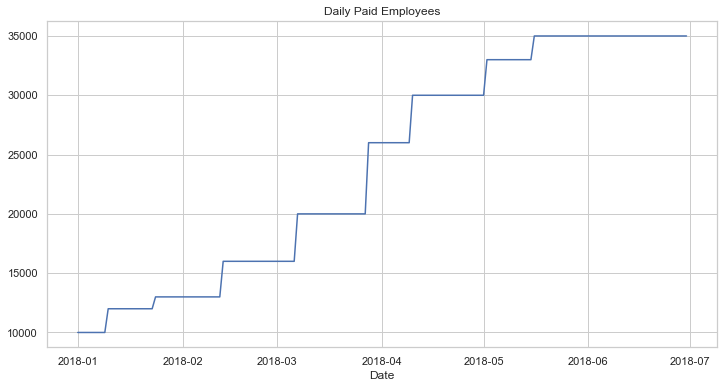

In [5]:
# Viz the data
# Viz paid employees
data_chats = data.drop(columns='paid_employees')
data_paid = data.drop(columns='chats')

plt.figure(figsize=(12,6))
plt.title("Daily Paid Employees")
sns.lineplot(data=data_paid, legend=False)
plt.xlabel("Date")

Text(0.5, 0, 'Date')

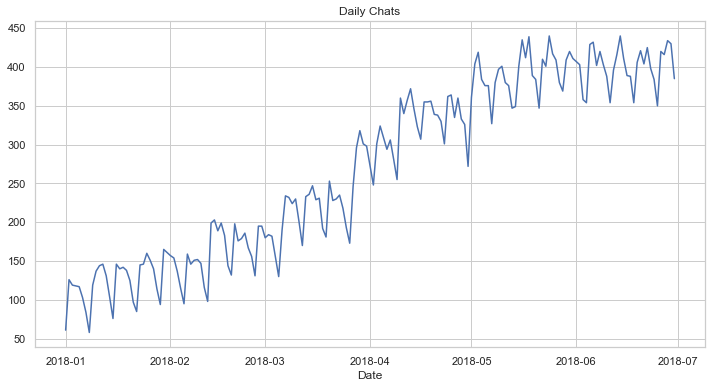

In [6]:
# Viz chats
plt.figure(figsize=(12,6))
plt.title("Daily Chats")
sns.lineplot(data=data_chats, legend=False)
plt.xlabel("Date")

In [7]:
# Is there a difference in number of chats by days of the week? Are there more chats on weekdays or weekends?
def expand_df(df):
    data = df.copy()
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    return data

data_expand = expand_df(data)

Text(0, 0.5, 'Chats')

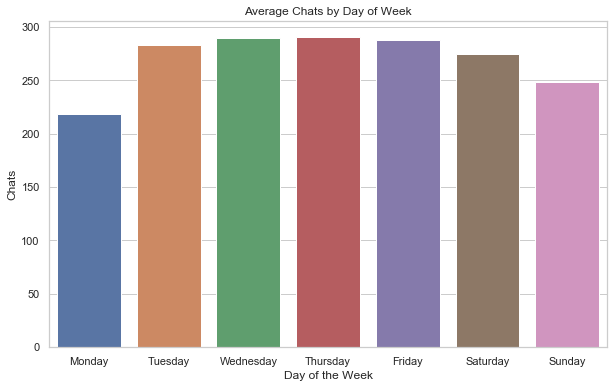

In [8]:
# Viz chats by day of the week

data_expand_dow = data_expand.groupby('dayofweek').chats.mean()
data_expand_dow.rename(index={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace=True)

plt.figure(figsize=(10,6))
plt.title("Average Chats by Day of Week")
sns.barplot(x=data_expand_dow.index, y=data_expand_dow)
plt.xlabel("Day of the Week")
plt.ylabel("Chats")

Text(0, 0.5, 'Chats')

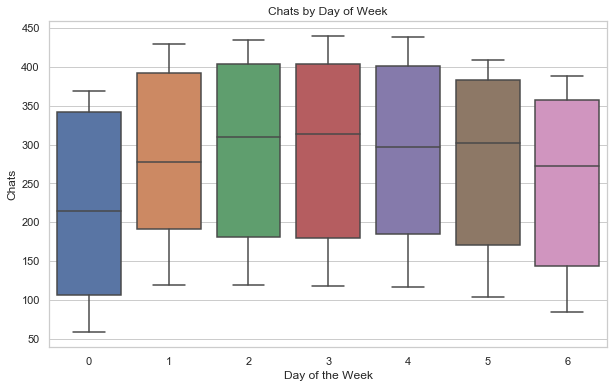

In [9]:
# Boxplot of chats by day of the week

plt.figure(figsize=(10,6))
plt.title("Chats by Day of Week")
sns.boxplot(x='dayofweek', y='chats', data=data_expand)
plt.xlabel("Day of the Week")
plt.ylabel("Chats")

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


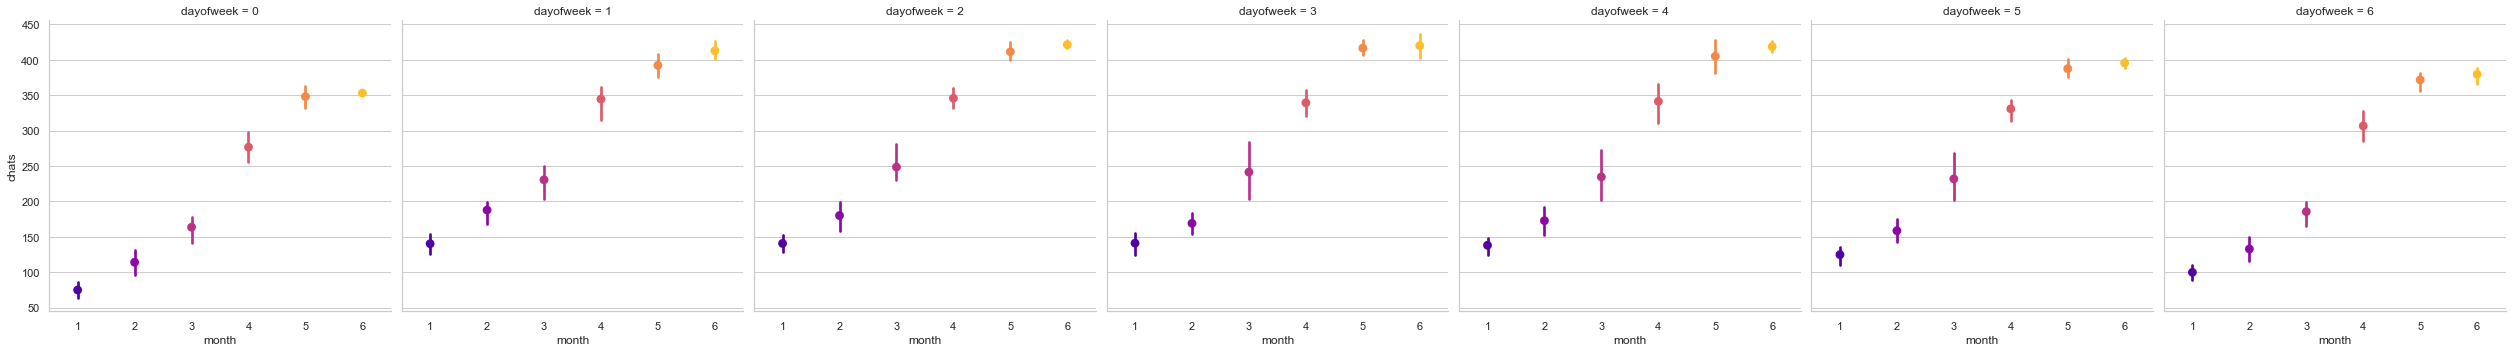

In [10]:
sns.factorplot(data=data_expand, x='month', y='chats', 
               col='dayofweek', palette='plasma')

Thursday appears to be the busiest day of the week while Monday has fewer chats on average.

# Is the time-series data stationary?
Most time-series models assumes the data is stationary (constant mean, variance, autocovariance). Our data's rolling mean appears to change with time. We can use the Dickey-Fuller test to check.


In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    # Determing rolling statistics
    rolmean = df[ts].rolling(window=12, center=False).mean()
    rolstd = df[ts].rolling(window=12, center=False).std()
    
    # Plot rolling statistics:
    plt.figure(figsize=(12,6))
    orig = plt.plot(df[ts],
                   color = 'blue',
                   label = 'Original')
    mean = plt.plot(rolmean,
                   color = 'red',
                   label = 'Rolling Mean')
    std = plt.plot(rolstd,
                  color = 'black',
                  label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts],
                     autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index = ['Test Statistic',
                                 'p-value',
                                 '# Lags Used',
                                 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

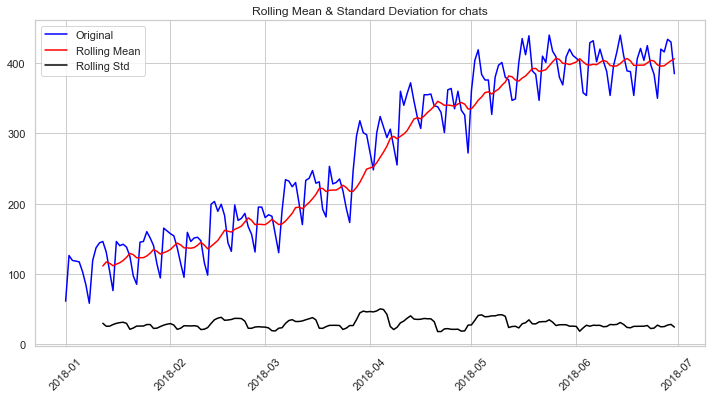

Results of Dickey-Fuller Test:
Test Statistic                  -1.041496
p-value                          0.737831
# Lags Used                     14.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64


In [12]:
test_stationarity(df=data_chats, ts='chats')

Looking at the chart, we can see the rolling mean is increasing over time while the rolling standard deviation appears to vary a bit. Because the rolling mean is not constant, this would imply the data is not stationary. Furthermore, because the test statistic is more than the critical values we cannot reject the null hypothesis ergo we can say the time-series is not stationary.

# Correcting data for stationarity
The trend (non-constant rolling mean) and seasonality (non-constant rolling variance) need to be corrected.
## Transforming, Smoothing, and Differencing the data
### Transforming
We can choose log, square root, cube root, etc to transform the data. Some will be better at smoothing than others.
### Smoothing
We can smooth (take rolling averages) over weekly or monthly averages. Because of the weekly cycle spotted earlier, I will smooth over a weekly average.
### Differencing
Will use first-order differencing

### Examine what transforming, smoothing, and differencing options yield the best results


In [13]:
# Rename chats to ts
data_chats = data_chats.rename(columns={'chats':'ts'})

In [14]:
def plot_transformed_data(df, ts, ts_transform):
  """
  Plot transformed and original time series data
  Source: Tamara Louie, PyData LA, October 2018, https://github.com/tklouie/PyData_LA_2018
  """
  # Plot time series data
  f, ax = plt.subplots(1,1)
  ax.plot(df[ts])
  ax.plot(df[ts_transform], color = 'red')

  # Add title
  ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
  ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
  ax.legend([ts, ts_transform])
  
  plt.show()
  plt.close()
  
  return

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff
date,,,,,,,,,
2018-01-07,84,4.430817,4.617812,104.000000,-0.203912,-20.000000,-0.186995,4.430817,0.000000
2018-01-08,58,4.060443,4.610608,103.571429,-0.370374,-45.571429,-0.550165,4.236469,-0.176026
2018-01-09,119,4.779123,4.602442,102.571429,0.718680,16.428571,0.176681,4.435531,0.343593
2018-01-10,137,4.919981,4.622565,105.142857,0.140857,31.857143,0.297416,4.575180,0.344801
2018-01-11,144,4.969813,4.651011,108.857143,0.049832,35.142857,0.318802,4.670456,0.299358


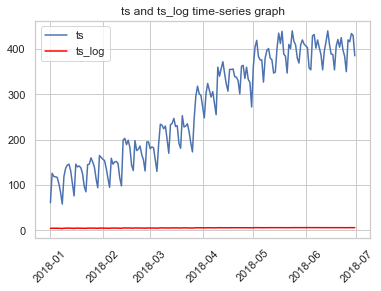

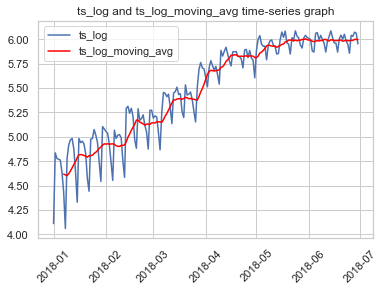

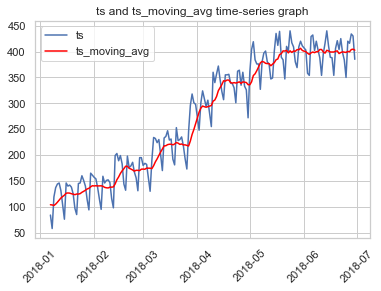

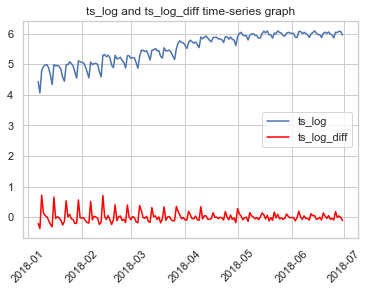

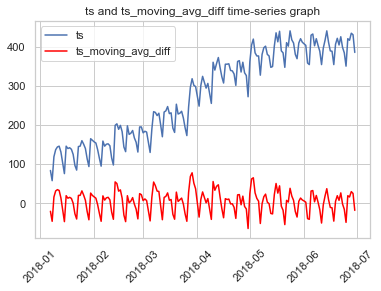

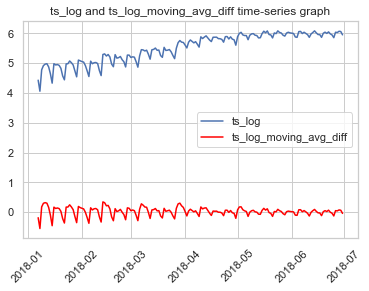

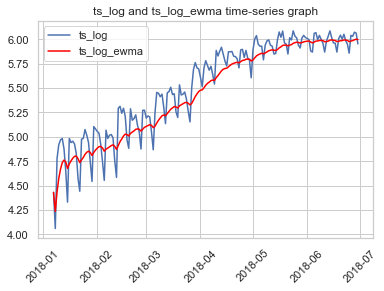

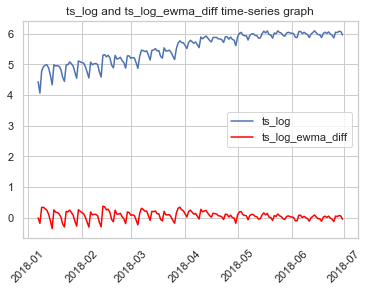

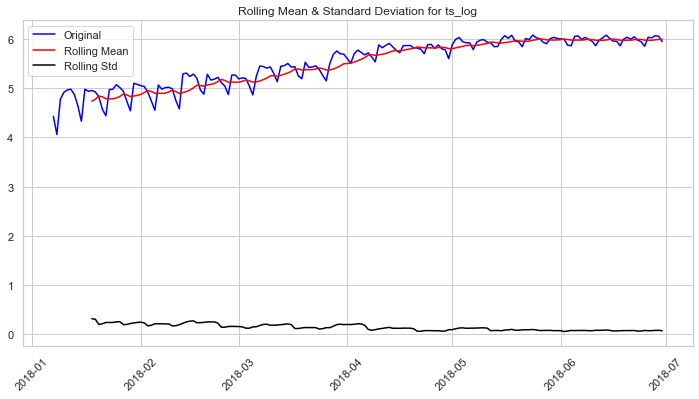

Results of Dickey-Fuller Test:
Test Statistic                  -2.082061
p-value                          0.251789
# Lags Used                     14.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


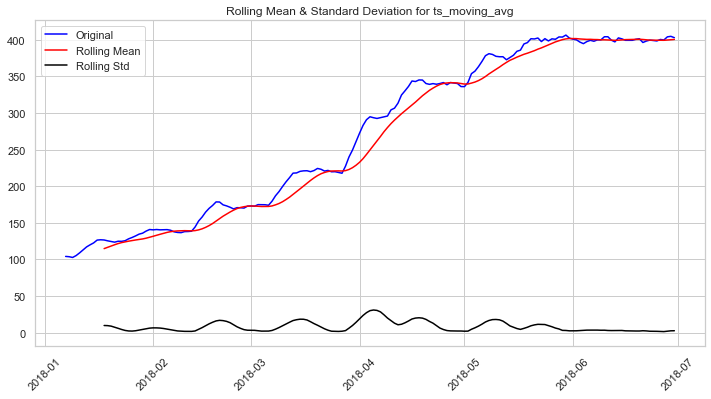

Results of Dickey-Fuller Test:
Test Statistic                  -1.206701
p-value                          0.670706
# Lags Used                     14.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


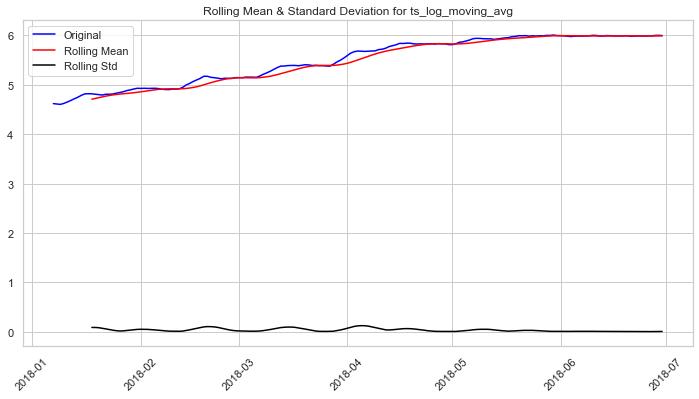

Results of Dickey-Fuller Test:
Test Statistic                  -2.762249
p-value                          0.063872
# Lags Used                     14.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


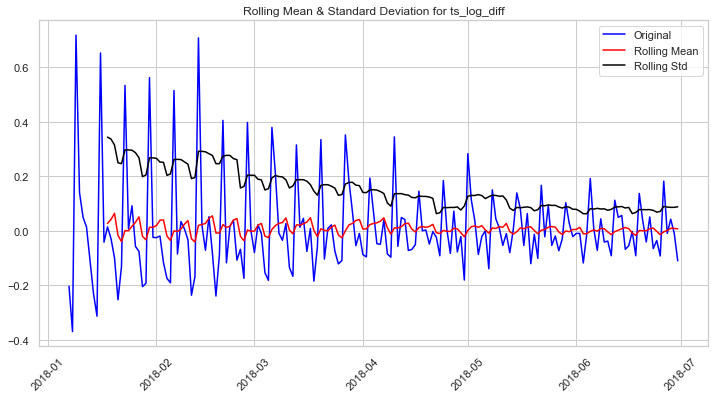

Results of Dickey-Fuller Test:
Test Statistic                  -3.188547
p-value                          0.020657
# Lags Used                     14.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


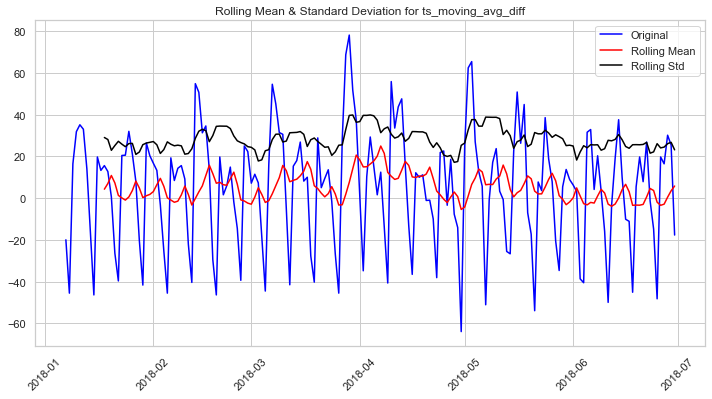

Results of Dickey-Fuller Test:
Test Statistic                  -3.162063
p-value                          0.022288
# Lags Used                     14.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


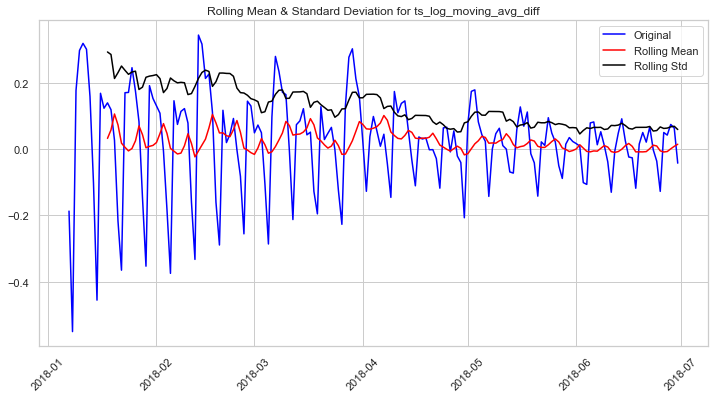

Results of Dickey-Fuller Test:
Test Statistic                  -3.770849
p-value                          0.003220
# Lags Used                     14.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


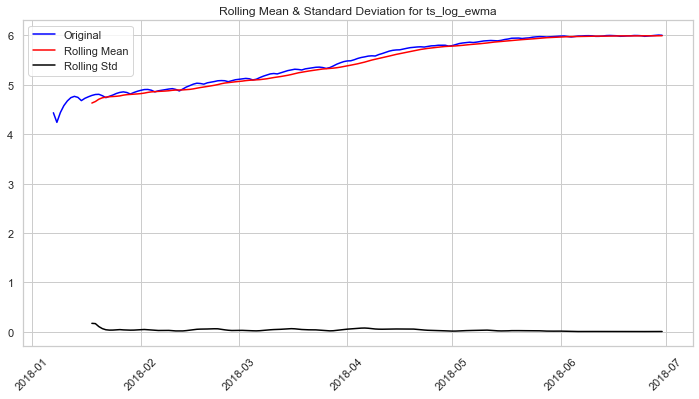

Results of Dickey-Fuller Test:
Test Statistic                  -1.919889
p-value                          0.322763
# Lags Used                     12.000000
Number of Observations Used    162.000000
Critical Value (1%)             -3.471374
Critical Value (5%)             -2.879552
Critical Value (10%)            -2.576373
dtype: float64


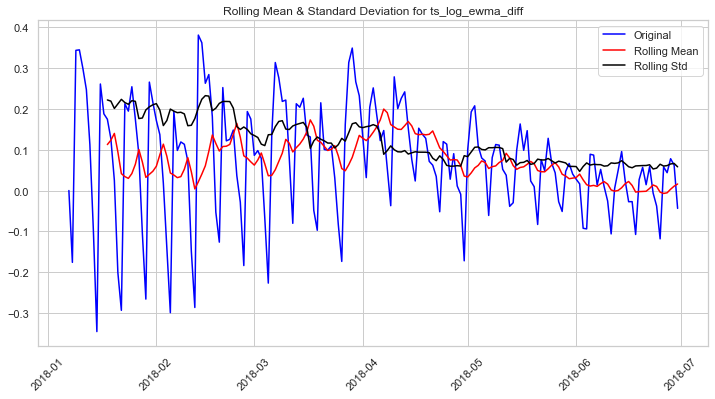

Results of Dickey-Fuller Test:
Test Statistic                  -1.718509
p-value                          0.421602
# Lags Used                     14.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


In [15]:
# Transformation - log ts
data_chats['ts_log'] = data_chats['ts'].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ts
data_chats['ts_log_moving_avg'] = data_chats['ts_log'].rolling(window = 7,
                                                               center = False).mean()

# Transformation - 7-day moving average ts
data_chats['ts_moving_avg'] = data_chats['ts'].rolling(window = 7,
                                                       center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
# data_chats['ts_log_diff'] = data_chats['ts_log'] - data_chats['ts_log'].shift()
data_chats['ts_log_diff'] = data_chats['ts_log'].diff()

# Transformation - Difference between ts and moving average ts
data_chats['ts_moving_avg_diff'] = data_chats['ts'] - data_chats['ts_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
data_chats['ts_log_moving_avg_diff'] = data_chats['ts_log'] - data_chats['ts_log_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
data_chats_transform = data_chats.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) ts
data_chats_transform['ts_log_ewma'] = data_chats_transform['ts_log'].ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

# Transformation - Difference between logged ts and logged EWMA ts
data_chats_transform['ts_log_ewma_diff'] = data_chats_transform['ts_log'] - data_chats_transform['ts_log_ewma']

# Display data
display(data_chats_transform.head())

# Plot data
plot_transformed_data(df = data_chats, 
                      ts = 'ts', 
                      ts_transform = 'ts_log')
# Plot data
plot_transformed_data(df = data_chats, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg')

# Plot data
plot_transformed_data(df = data_chats_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg')

# Plot data
plot_transformed_data(df = data_chats_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_diff')

# Plot data
plot_transformed_data(df = data_chats_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg_diff')

# Plot data
plot_transformed_data(df = data_chats_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = data_chats_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma')

# Plot data
plot_transformed_data(df = data_chats_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = data_chats_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = data_chats_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = data_chats_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = data_chats_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = data_chats_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = data_chats_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = data_chats_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = data_chats_transform,
                  ts = 'ts_log_ewma_diff')

The best option in making the data more stationary with time is to apply a log transformation, weekly moving average smoothing, and differencing. This can be concluded by examining the p-value in each of the Dickey-Fuller tests. Because the test statistic is smaller than the 1% critical values, we can say with 99% confidence that this is a stationary series.

However, even with a low p-value I am a little worried about the variance as it appears to decrease over time (ergo, not constant). 

### Decomposing

Let us go a little further and decompose the time-series data into its trend, seasonality, and residual components.

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


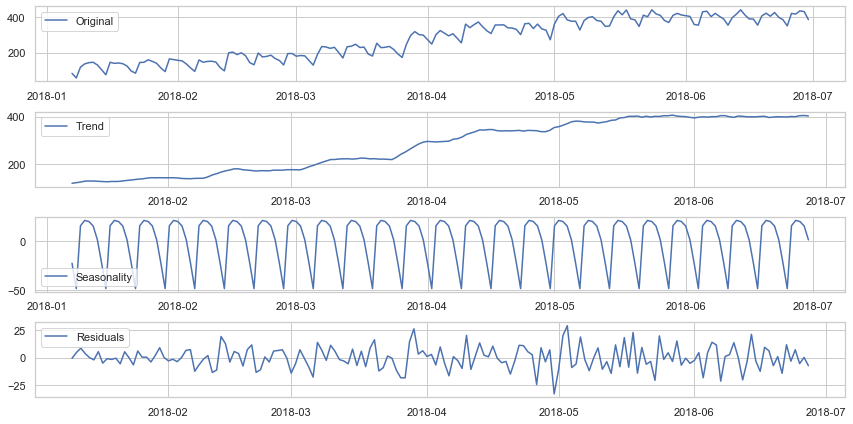

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data_chats_transform['ts'])
data_chats_transform.loc[:,'trend'] = decomposition.trend
data_chats_transform.loc[:,'seasonal'] = decomposition.seasonal
data_chats_transform.loc[:,'residual'] = decomposition.resid

plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(data_chats_transform['ts'], label='Original')
plt.legend()
plt.subplot(412)
plt.plot(data_chats_transform['trend'], label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(data_chats_transform['seasonal'],label='Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(data_chats_transform['residual'], label='Residuals')
plt.legend()
plt.tight_layout()

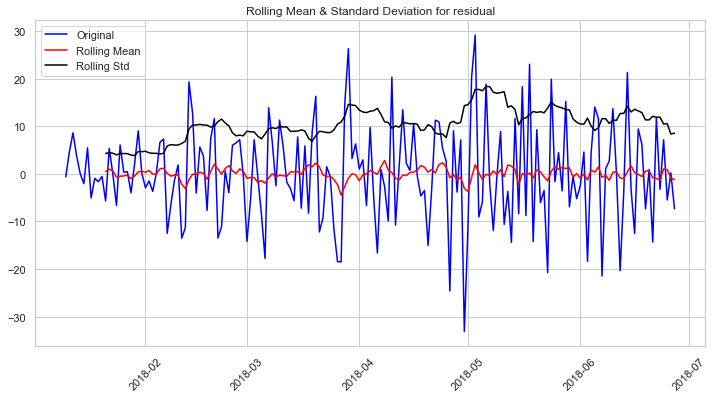

Results of Dickey-Fuller Test:
Test Statistic                -8.165110e+00
p-value                        8.926648e-13
# Lags Used                    9.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


In [17]:
# Run Dickey-Fuller test on residuals
test_stationarity(df = data_chats_transform.dropna(), ts = 'residual')

Removing the trend and seasonality makes the residual data stationary. The test statistic is much lower than the 1% critical value. As such the time-series is considered stationary.

# Model Building
## ARIMA Model
ARIMA 'p' and 'q' values will be determined with the help of ACF and PACF plots.


D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


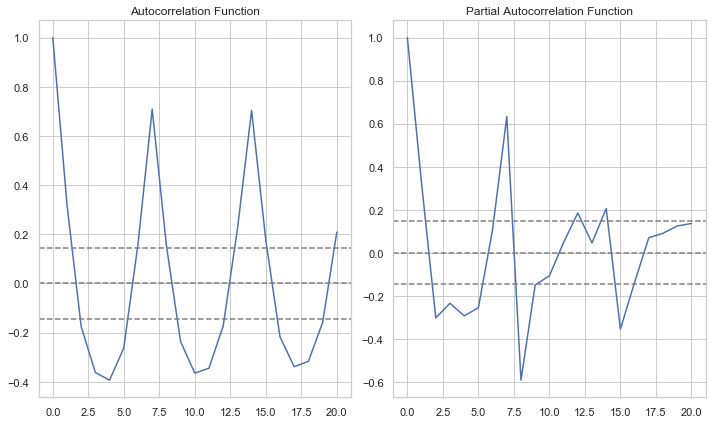

In [18]:
#ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(np.array(data_chats_transform['ts_log_moving_avg_diff']), nlags=20)
lag_pacf = pacf(np.array(data_chats_transform['ts_log_moving_avg_diff']), nlags=20, method='ols')

#ACF
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_chats['ts'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_chats['ts'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_chats['ts'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_chats['ts'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

We see it cross the upper confidence line at 1 on both plots.

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


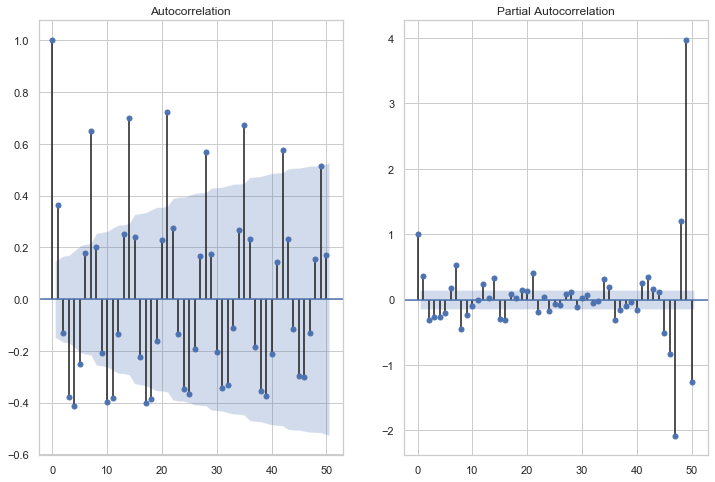

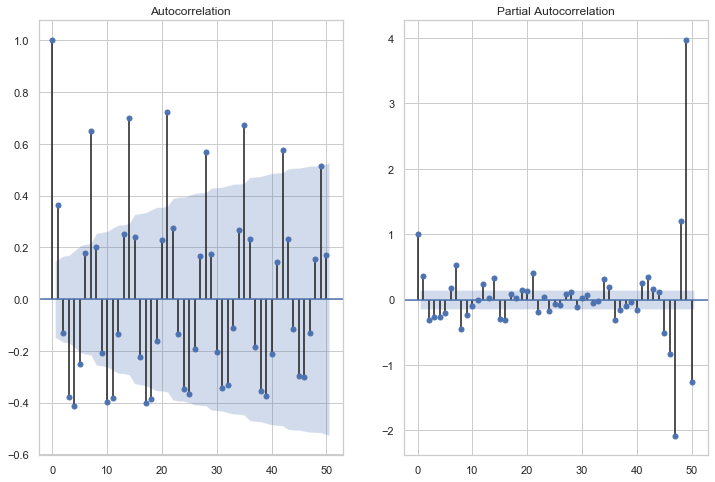

In [19]:
plt.figure(figsize = (12, 8))
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.subplot(121); plot_acf(data_chats_transform['ts_moving_avg_diff'], lags = 50, ax = plt.gca())
plt.subplot(122); plot_pacf(data_chats_transform['ts_moving_avg_diff'], lags = 50, ax = plt.gca())

Looking at the autocorrelation, we can spot heteroscedasticity. From here we could:
1. Correct for this and then run a __SARIMA__ model to take into account the weekly seasonality
2. Run a __Prophet__ model which will correct the heteroscedasticity and specializes in working with seasonal data

I am going to go with number 2 and create a __Prophet__ model as it will reduce the risk of human error and is the quicker option.

# Prophet Model

In [20]:
from fbprophet import Prophet
import datetime
from datetime import datetime

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
def days_between(d1, d2):
    """Calculate the number of days between d1 (inclusive) and d2 (inclusive)"""
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days + 1)

In [ ]:
"""
Using the Prophet inputs page created by Tamara Louie, PyData LA, October 2018 to simplify the process and reduce the risk of missing an input (Prophet has a ton of inputs).
Source: https://github.com/tklouie/PyData_LA_2018
"""
# Inputs for query

date_column = 'dt'
metric_column = 'ts'
table = data_chats
start_training_date = '2018-01-01'
end_training_date = '2018-06-30'
start_forecasting_date = '2018-07-01'
end_forecasting_date = '2018-07-31'
#year_to_estimate = '2018'

# Inputs for forecasting

# future_num_points
# If doing different time intervals, change future_num_points
future_num_points = days_between(start_forecasting_date, end_forecasting_date)

cap = None # 2e6

# growth: default = 'linear'
# Can also choose 'logistic'
growth = 'linear'

# n_changepoints: default = 25, uniformly placed in first 80% of time series
n_changepoints = 25 

# changepoint_prior_scale: default = 0.05
# Increasing it will make the trend more flexible
changepoint_prior_scale = 0.05 

# changpoints: example = ['2016-01-01']
changepoints = None 

# holidays_prior_scale: default = 10
# If you find that the holidays are overfitting, you can adjust their prior scale to smooth them
holidays_prior_scale = 10 

# interval_width: default = 0.8
interval_width = 0.8 

# mcmc_samples: default = 0
# By default Prophet will only return uncertainty in the trend and observation noise.
# To get uncertainty in seasonality, you must do full Bayesian sampling. 
# Replaces typical MAP estimation with MCMC sampling, and takes MUCH LONGER - e.g., 10 minutes instead of 10 seconds.
# If you do full sampling, then you will see the uncertainty in seasonal components when you plot:
mcmc_samples = 0

# holiday: default = None
# thanksgiving = pd.DataFrame({
#   'holiday': 'thanksgiving',
#   'ds': pd.to_datetime(['2014-11-27', '2015-11-26',
#                         '2016-11-24', '2017-11-23']),
#   'lower_window': 0,
#   'upper_window': 4,
# })
# christmas = pd.DataFrame({
#   'holiday': 'christmas',
#   'ds': pd.to_datetime(['2014-12-25', '2015-12-25', 
#                         '2016-12-25','2017-12-25']),
#   'lower_window': -1,
#   'upper_window': 0,
# })
# holidays = pd.concat((thanksgiving,christmas))
holidays = None

daily_seasonality = True
#weekly_seasonality = True

In [ ]:
# Adjust df to meet Prophet's column naming standard
# Data
df_prophet = data_chats[['ts']]

# reset index
df_prophet = df_prophet.reset_index()

# rename columns
df_prophet = df_prophet.rename(columns = {'date': 'ds', 'ts': 'y'})

# Change 'ds' type from datetime to date (necessary for FB Prophet)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Change 'y' type to numeric (necessary for FB Prophet)
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='ignore')

# Remove any outliers
# df.loc[(df_['ds'] > '2016-12-13') & (df_['ds'] < '2016-12-19'), 'y'] = None

In [ ]:
def create_daily_forecast(df,
#                           cap,
                          holidays,
                          growth,
                          n_changepoints = 25,
                          changepoint_prior_scale = 0.05,
                          changepoints = None,
                          holidays_prior_scale = 10,
                          interval_width = 0.8,
                          mcmc_samples = 1,
                          future_num_points = future_num_points, 
                          daily_seasonality = True,
#                          weekly_seasonality = True
                         ):
  """
  Create forecast
  """
  
  # Create copy of dataframe
  df_ = df.copy()

  # Add in growth parameter, which can change over time
  #     df_['cap'] = max(df_['y']) if cap is None else cap

  # Create model object and fit to dataframe
  m = Prophet(growth = growth,
              n_changepoints = n_changepoints,
              changepoint_prior_scale = changepoint_prior_scale,
              changepoints = changepoints,
              holidays = holidays,
              holidays_prior_scale = holidays_prior_scale,
              interval_width = interval_width,
              mcmc_samples = mcmc_samples, 
              daily_seasonality = daily_seasonality,
#              weekly_seasonality = weekly_seasonality
             )

  # Fit model with dataframe
  m.fit(df_)

  # Create dataframe for predictions
  future = m.make_future_dataframe(periods = future_num_points)
  #     future['cap'] = max(df_['y']) if cap is None else cap

  # Create predictions
  fcst = m.predict(future)

  # Plot
  m.plot(fcst);
  m.plot_components(fcst)

  return fcst

In [ ]:
# Re-register pd converters
pd.plotting.register_matplotlib_converters()

# Forecast data
fcst = create_daily_forecast(df_prophet,
#                              cap,
                             holidays,
                             growth,
                             n_changepoints,
                             changepoint_prior_scale,
                             changepoints, 
                             holidays_prior_scale,
                             interval_width,
                             mcmc_samples,
                             future_num_points, 
                             daily_seasonality,
#                             weekly_seasonality
                            )

Let's grab the predicted values for the month of July.

In [ ]:
fcst.tail(3)

In [ ]:
predict_july = fcst[['ds', 'yhat']].set_index('ds')
predict_july = predict_july['2018-07-01':]
predict_july.tail(3)

In [ ]:
predict_july.describe()

In [ ]:
plt.figure(figsize=(16,6))
sns.lineplot(data=predict_july)
plt.title("Predicted Chats in July 2018")
plt.xlabel("Date")
plt.ylabel("Chats")

# Q2: Recommendation on the number of nurses needed per day in July
If we look at the predicted values above, on the slowest day we have a minimum of 359 chats and on the busiest day we have a max of 434 chats. There is an average of 409 chats per day in July.
Assuming that:
1. Nurses work in 8-hour shifts, we have 3 shifts of nurses in a day.
2. Calls are spread out evenly throughout the day (we won't have all 400+ calls during the same hour). This is likley not true but lets use it in this example.
3. The average duration of a chat is 30 minutes

Using 409 chats, the average number of chats in July, spread evenly over the course of a day results in 17 chats per hour. With the chat duration assumption of 30 minutes, the minium number of nurses required to meet this demand is 9 nurses per hour. With 8-hour shifts, we will __need 27 nurses per day in July to handle the average number of chats during the month__.

# Q3: Evaluate the Accuracy of the Model
In order to test our forecast, I will train the model on data from 2018-01-01 to 2018-05-31 and test it against June's actual values. This means the model will be trained on 151 of the 181 records (83%). The test data will be the last month which has 30 of the 181 records (17%).

In [ ]:
df_train = data_chats.loc[:'2018-05-31']
df_test = data_chats.loc['2018-06-01':]

# Check data was divided correctly
print(df_train['ts'].count(), df_test['ts'].count(), sep='\n')

Adjust the inputs for the Prophet model.

In [ ]:
# Inputs for query
date_column = 'dt'
metric_column = 'ts'
table = df_train
start_training_date = '2018-01-01'
end_training_date = '2018-05-31'
start_forecasting_date = '2018-06-01'
end_forecasting_date = '2018-06-30'

In [ ]:
# Adjust df to meet Prophet's column naming standard
# Data
df_prophet = df_train[['ts']]

# reset index
df_prophet = df_prophet.reset_index()

# rename columns
df_prophet = df_prophet.rename(columns = {'date': 'ds', 'ts': 'y'})

# Change 'ds' type from datetime to date (necessary for FB Prophet)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Change 'y' type to numeric (necessary for FB Prophet)
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='ignore')

# Remove any outliers
# df.loc[(df_['ds'] > '2016-12-13') & (df_['ds'] < '2016-12-19'), 'y'] = None

In [ ]:
# Re-register pd converters
pd.plotting.register_matplotlib_converters()

# Forecast data
fcst = create_daily_forecast(df_prophet,
#                              cap,
                             holidays,
                             growth,
                             n_changepoints,
                             changepoint_prior_scale,
                             changepoints, 
                             holidays_prior_scale,
                             interval_width,
                             mcmc_samples,
                             future_num_points, 
                             daily_seasonality,
#                             weekly_seasonality
                            )

In [ ]:
fcst.tail(3)

To evaluate the accuracy of the model, we have already divided the data into training data and testing data using a 83% train and 17% test split. We will now combine the forecast values in the fcst dataframe with the actual values and compare them by calculating the MAPE and MAE.

In [ ]:
df_compare = fcst.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(data_chats['ts'])
df_compare.head()

Going to use MAPE and MAE to measure quality of the model

In [ ]:
def calc_fcst_errors(df, fcst_size):
    """ Calculates MAPE and MAE of the Prophet forecast.
    Uses df_compare dataframe (yhat, yhat_lower, yhat_upper, and ts columns) and fcst_size (default argument is the future_num_points input from Prophet's inputs)"""
    df = df.copy()
    
    df['e'] = df['ts'] - df['yhat']
    df['p'] = 100 * df['e'] / df['ts']
    
    # Separate out the predicted values in the forecast
    predict_values = df[-fcst_size:]
    
    # Predicted average absolute error
    error_mean = lambda err: np.mean(np.abs(predict_values[err]))
    
    # Calculate MAPE & MAE
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [ ]:
for err_name, err_value in calc_fcst_errors(df = df_compare, fcst_size = future_num_points).items():
    print(err_name, err_value)

The MAPE of the model, or the relative error, is about 12.4%. The MAE states that the model is wrong by 49.4 predicts on average.

Let us take a look at the model.

In [ ]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [ ]:
def show_forecast(df_compare, future_num_points, num_values):
    def create_go(name, column, num, **kwargs):
        points = df_compare.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', future_num_points,
                            line=dict(width=0),
                            marker=dict(color="aqua"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', future_num_points,
                            line=dict(width=0),
                            marker=dict(color="aqua"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', future_num_points,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'ts', num_values,
                       marker=dict(color="red"))
    
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Chats'), title='Daily Chats', showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [ ]:
show_forecast(df_compare, future_num_points, 181)

Visually, we can see the model is maintaing the upwards trend based on the training data from January to the end of May. In June, the actual values experienced a decrease in the trend. Overall, the model is a good start with the limited amount of data available. In a few years we might even see a yearly seasonality to the data as well.

# Q4: How to evaluate the impact of the model
If the team starts using the model to staff the clinic, we can begin to evaluate the impact of the model by measuring and comparing the user wait times before they're connected to a nurse. If the wait times are too long, it would imply we are short on nurses which degrades the quality of the service. If the average wait time is near zero, it would imply we have more active nurses than necessary which indicates that our costs are potentially higher than necessary.

If the wait time is at the target value, it would indicate that the model is accurately predicting the number of chats and therefore the number of active nurses required.

Note that we can also collect and compare July's actual values to it's predicted values to measure its accuracy.

Also note that the model's accuracy will degrade the further out you forecast.

# Q5: Improving the model's accuracy and its impact on cost and quality of service
To improve the model's accuracy and its impact on quality of service we can:
1. Run the prophet model with transformed data. For example, we could run the Prophet model with the log of our time-series, or the log and difference.
2. Optimize the inputs of our Prophet model. We could evaluate with a logistic growth or add in holidays to see if they improve the accuracy of the model.
3. Create a SARIMA model, optimizing its 'p', 'q', and 'd' values, to see if it will produce a model with better accuracy.
4. Explore different methods of improving the stationarity of the time-series data.
5. Explore other types of models such as recurrent neural networks or long short-term memory networks.